In [46]:
from pandas import Series
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures #для создания полиномиальных признаков

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [47]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [48]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [49]:
Dir_data = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv(Dir_data+'train.csv')
data_test = pd.read_csv(Dir_data+'test.csv')
sample_submission = pd.read_csv(Dir_data+'sample_submission.csv')

In [50]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['sample'] = 1 # помечаем где у нас трейн
data_test['sample'] = 0 # помечаем где у нас тест
data_test['default'] = 2 # в тесте у нас нет значения default, мы его должны предсказать, поэтому пока просто заполняем нулями

data = data_test.append(data_train, sort=False).reset_index(drop=True) # объединяем

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

<AxesSubplot:>

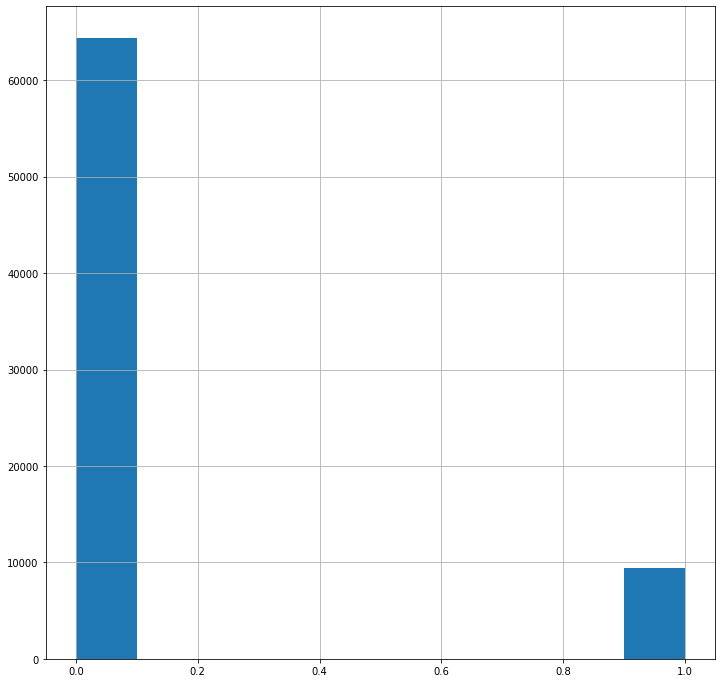

In [52]:
# which kind of clients prevailing?
data.default[data.default!=2].hist()

# 1. Обрабатываем значения Nan

**Из анализа видно, что пропуски есть только в признаке education, поэтому добавим самую популярную переменную вместо пропусков. И сохраним информацию о наблюдениях с пропусками**

In [53]:
# quantity of nan data
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [54]:
data['education_isNAN'] = pd.isna(data['education']).astype('uint8')

<AxesSubplot:>

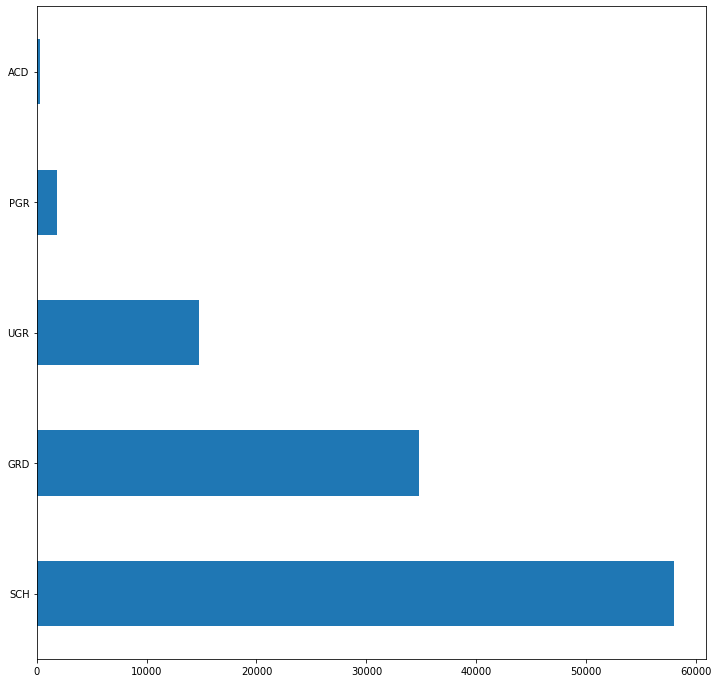

In [55]:
data.education.value_counts().plot.barh()

In [56]:
a = data.education.value_counts(ascending=False).index

data['education'] = data['education'].fillna(a[0])

In [57]:
data['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

# 2. Обработка признаков

In [58]:
#Функция для анализа квантилей и выбросов
def func_quantile(df, col):   
    
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    # Подсчитаем количество выбросов
    print("Количество выбросов в столбце",col,":",df[df[col]<perc25 - 1.5*IQR][col].count() + df[df[col]>perc75 + 1.5*IQR][col].count())
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend() 
    
    
#Функция для заполнения выбросов ближайшим квантилем
def filling_quantile(df, col): #quant=0.25 или 0.75
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    high_border = perc75 + 3*IQR
    low_border = perc25 - 3*IQR
    for i in range(len(df[col])):
        if df[col][i] > perc75:
            df[col][i] = perc75
        elif df[col][i] < perc25:
            df[col][i] = perc25
    return df[col]

client_id - идентификатор клиента

education - уровень образования

sex - пол заёмщика

age - возраст заёмщика

car - флаг наличия автомобиля

car_type - флаг автомобиля-иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия «хорошей» работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заёмщика

foreign_passport - наличие загранпаспорта

default - наличие дефолта

In [59]:
#добавим новый признак, который в себе содержит разницу между датой app_date и сегодняшним числом в днях
data.app_date = data.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [60]:
data['app_date_fromnow'] = datetime.now() - data.app_date

In [61]:
data['app_date_fromnow'] = data['app_date_fromnow'].apply(lambda x: x.days)

In [62]:
# рассмотрим категории возрастов 
#data.age.value_counts()
#data['age_cat']= pd.cut(data.age, 3,labels=[1,2,3])
#data['age_cat']
#data['income_cat']= pd.cut(data.age, 4,labels=[1,2,3,4])
#data['income_cat']

**Разделим признаки на следующие типы: бинарные, категориальные и числовые**

In [63]:
bin_cols = ['sex','car','car_type','foreign_passport','good_work']
cat_cols = ['education','home_address','sna','first_time','work_address']
num_cols = ['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating','app_date_fromnow']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


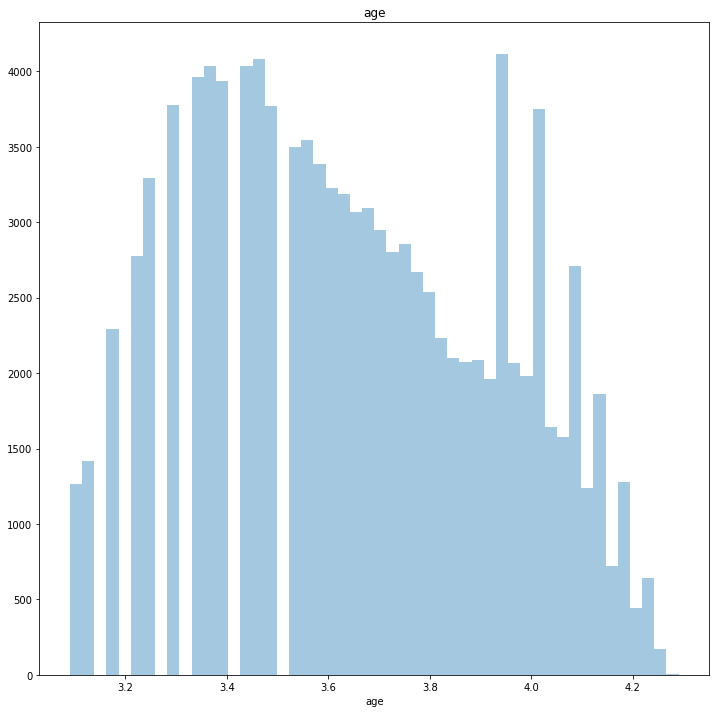

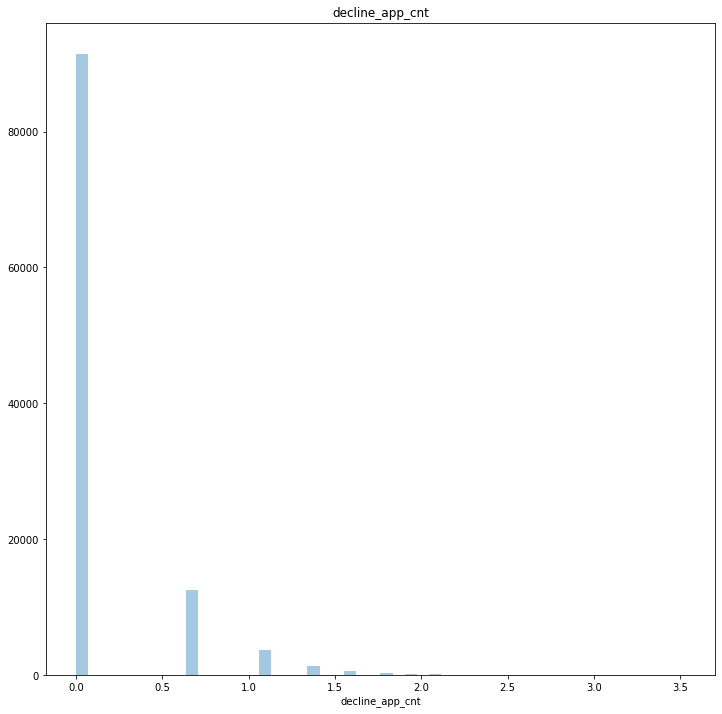

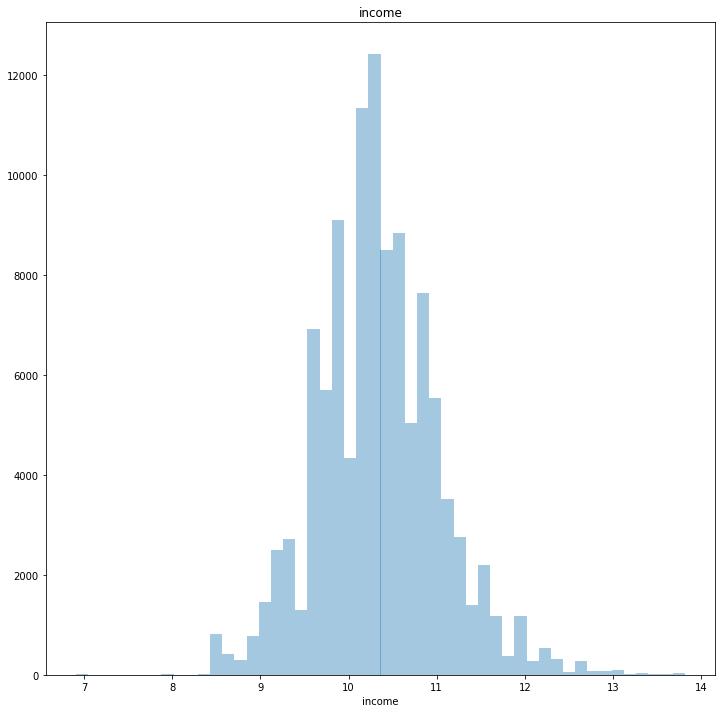

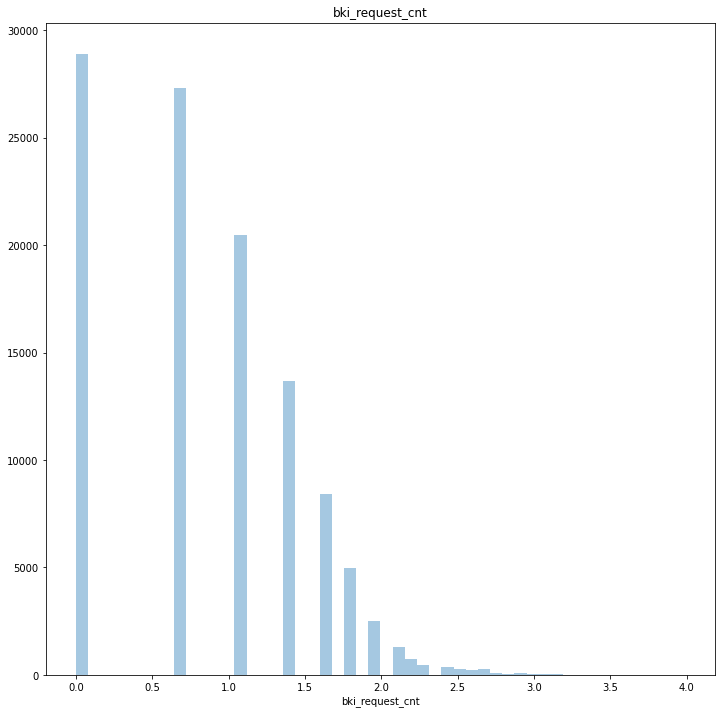

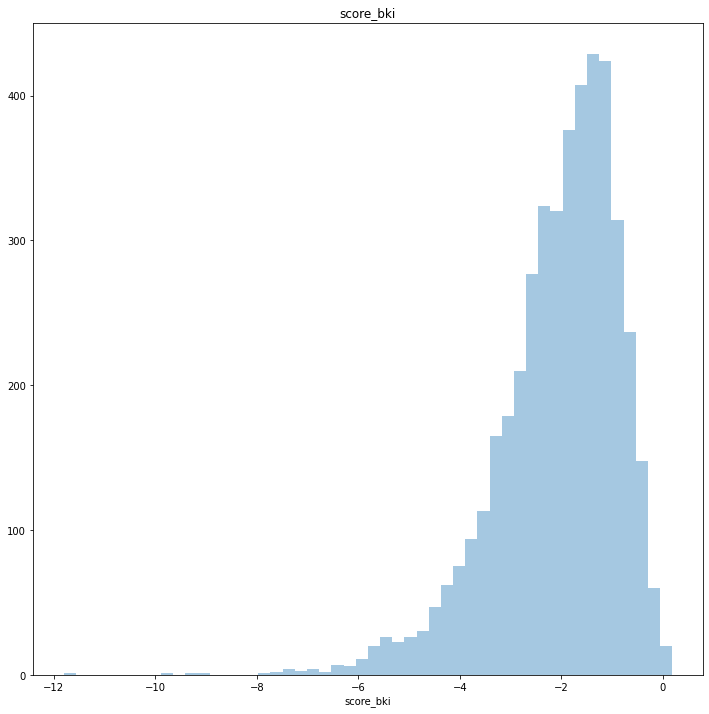

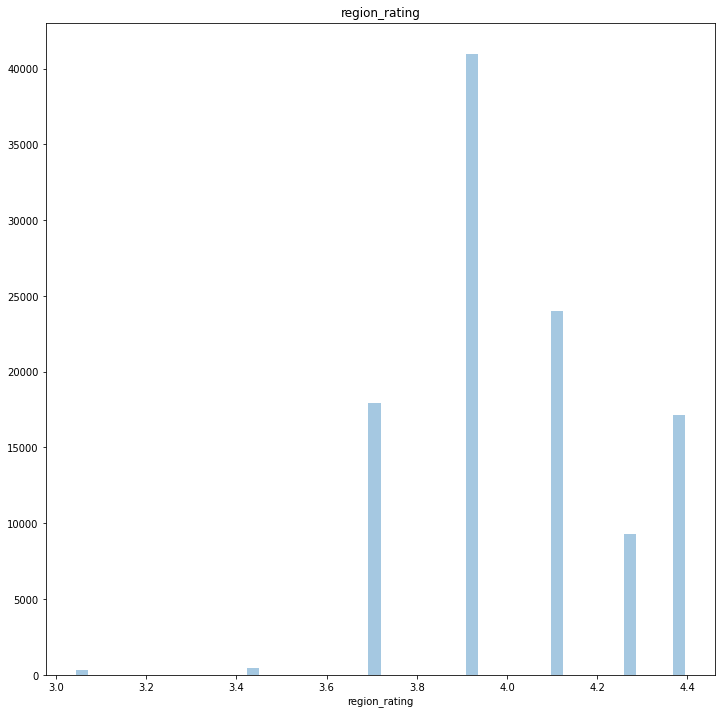

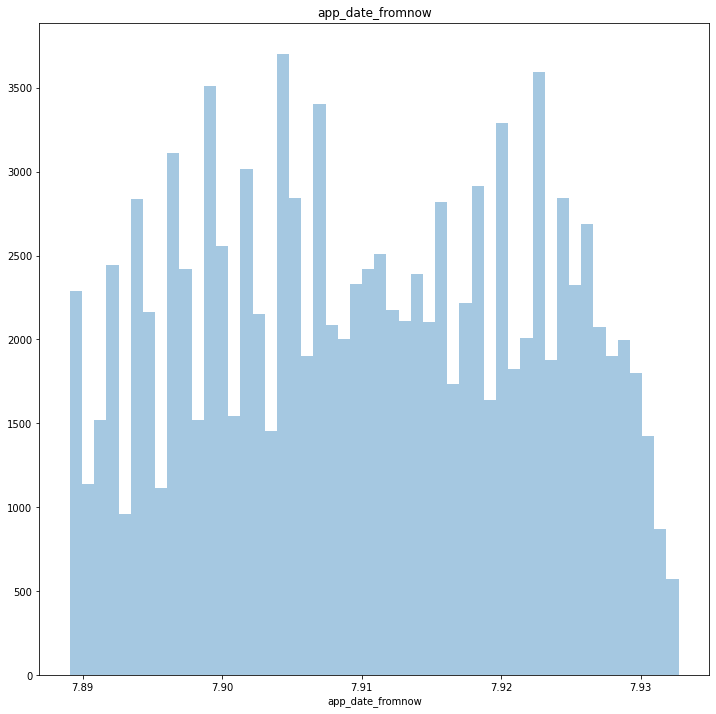

In [64]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i].apply(lambda x: np.log(x + 1)), kde = False, rug=False)
    plt.title(i)
    plt.show()

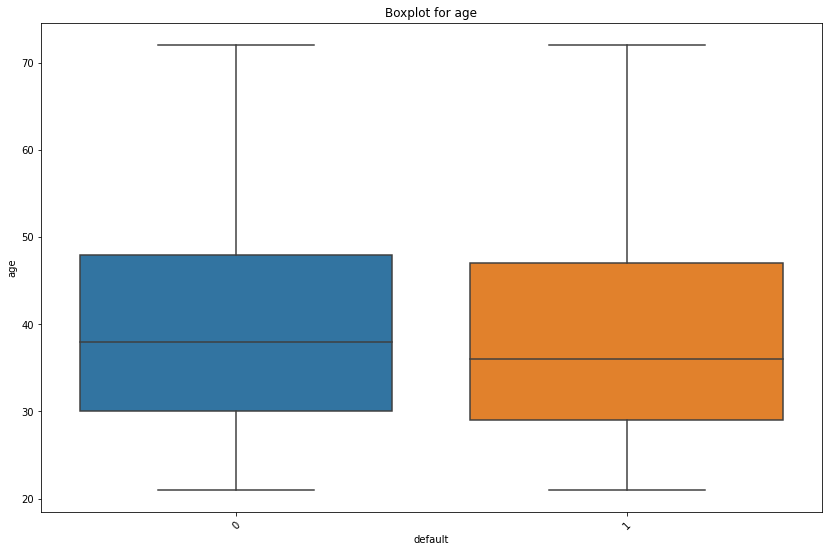

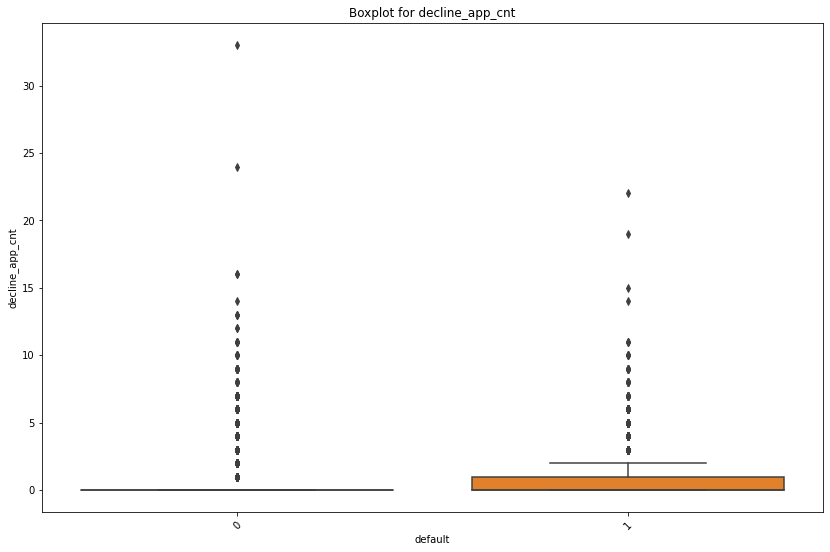

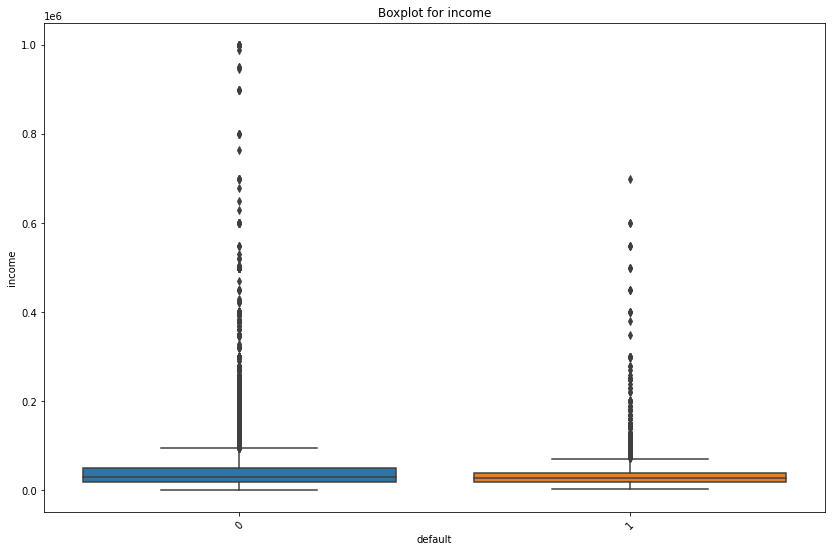

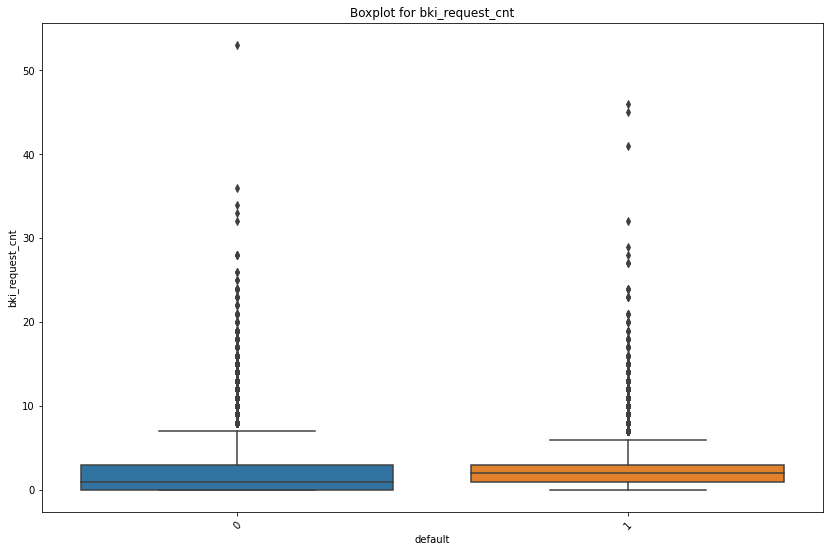

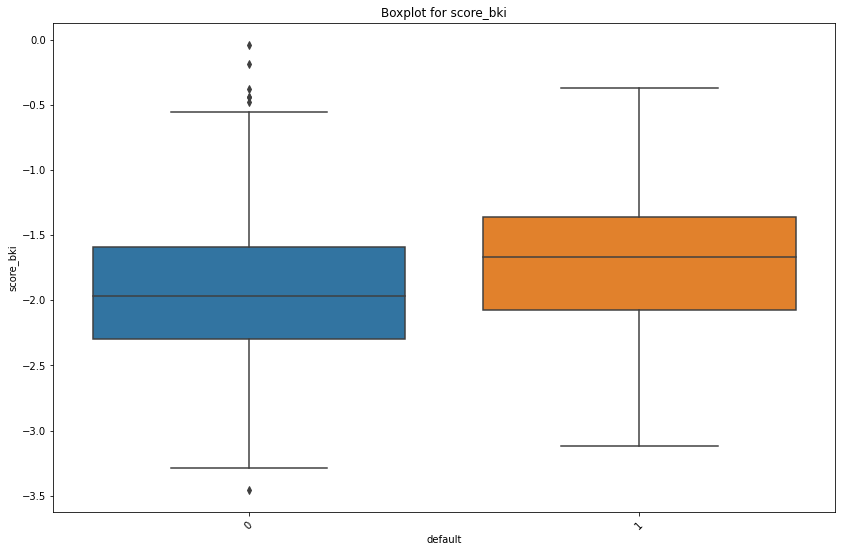

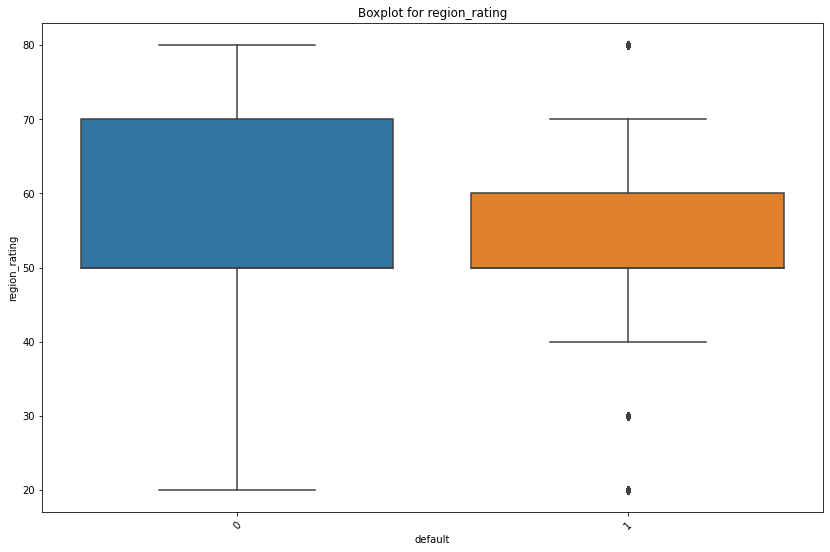

In [65]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 9))
    sns.boxplot(x='default', y=column,
                data=data_train.loc[data.loc[:, column].isin(
                    data_train.loc[:, column].value_counts().index[:20])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in num_cols[:-1]:
    get_boxplot(col)

In [66]:
#Избавимся от выбросов
#если убрать выбросы, то это ухудшит модель
#data['income'] = filling_quantile(data, 'income')
#data['bki_request_cnt'] = filling_quantile(data, 'bki_request_cnt')

<AxesSubplot:>

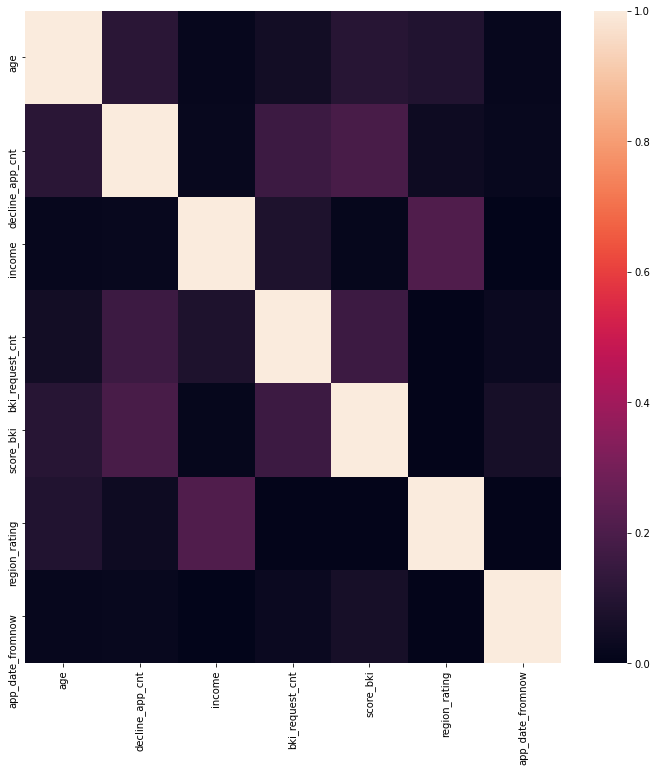

In [67]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

<AxesSubplot:>

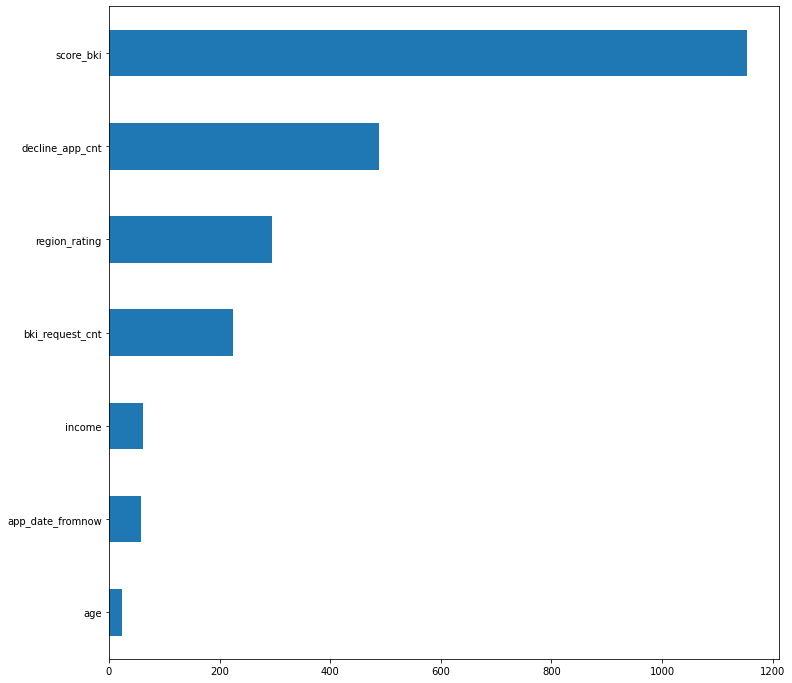

In [68]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [69]:
#imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
#                                     discrete_features =True), index = bin_cols + cat_cols)
#imp_cat.sort_values(inplace = True)
#imp_cat.plot(kind = 'barh')

In [70]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


<AxesSubplot:>

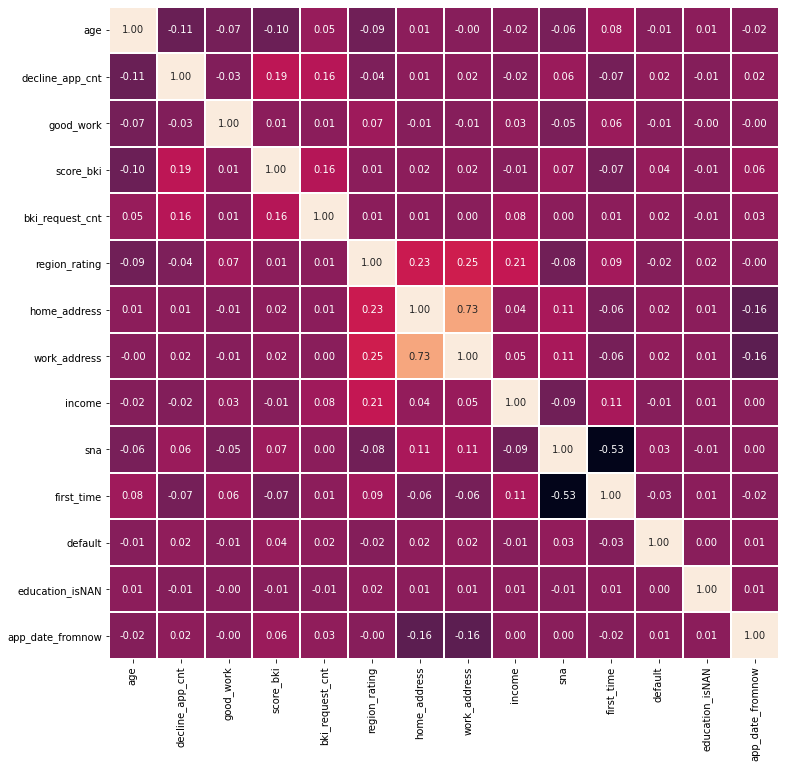

In [71]:
plt.rcParams['figure.figsize'] = (12,12)
sns.heatmap(data.drop(['sample','client_id'], axis=1).corr(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)

### Самая сильная корреляция у двух пар признаков:
### car и car_type (0.70)
### work_address и home_address (0.73)

In [72]:
#data['car+car_type'] = data['car']+data['car_type']
#закодируем новую колонку
#data['car+car_type'] = label_encoder.fit_transform(data['car+car_type'])

In [73]:
#Удалим рабочий адрес, он менее скоррелирован с целевой переменной.
#ухудшает модель, поэтому оставим
#data = data.drop(['work_address'],axis=1)

# Применим к:
##    1) бинарным признакам - LabelEncoder,
##    2) категориальным признакам - get_dummies,
##    3) числовым признакам - StandardScaler

In [74]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,education_isNAN,app_date_fromnow
0,74835,2014-03-22,GRD,1,29,1,1,0,0,-2.271884,...,1,2,50000,1,4,0,0,2,0,2706
1,17527,2014-01-24,SCH,0,39,0,0,5,0,-1.504999,...,1,2,5000,4,3,0,0,2,0,2763
2,75683,2014-03-23,UGR,1,50,1,1,0,0,-1.691339,...,1,2,30000,1,3,1,0,2,0,2705
3,26883,2014-02-03,SCH,1,56,0,0,0,0,-2.374182,...,1,2,17000,1,3,0,0,2,0,2753
4,28862,2014-02-04,GRD,0,38,0,0,0,0,-2.487502,...,2,3,120000,1,3,0,0,2,0,2752


In [75]:
data = pd.get_dummies(data,columns=cat_cols)

In [76]:
# Стандартизация числовых переменных
for column in num_cols:
    scaler = StandardScaler()
    Ranking_norm = scaler.fit_transform(data.loc[:,[column]]) 
    data.loc[:, [column]] = Ranking_norm


### Создание полиномиальных признаков

In [77]:
#Создадим признаки на основе двух хорошо скоррелированных колонок
#они не улучшают нашу модель
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(data[['income', 'foreign_passport']])
poly_features

array([[ 1.        ,  0.19796134,  0.        ,  0.03918869,  0.        ,
         0.        ],
       [ 1.        , -0.79323837,  0.        ,  0.62922712, -0.        ,
         0.        ],
       [ 1.        , -0.24257187,  1.        ,  0.05884111, -0.24257187,
         1.        ],
       ...,
       [ 1.        ,  0.08782804,  0.        ,  0.00771376,  0.        ,
         0.        ],
       [ 1.        , -0.61702509,  0.        ,  0.38071996, -0.        ,
         0.        ],
       [ 1.        , -0.35270517,  0.        ,  0.12440094, -0.        ,
         0.        ]])

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 36 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   sex               110148 non-null  int64         
 3   age               110148 non-null  float64       
 4   car               110148 non-null  int64         
 5   car_type          110148 non-null  int64         
 6   decline_app_cnt   110148 non-null  float64       
 7   good_work         110148 non-null  int64         
 8   score_bki         110148 non-null  float64       
 9   bki_request_cnt   110148 non-null  float64       
 10  region_rating     110148 non-null  float64       
 11  income            110148 non-null  float64       
 12  foreign_passport  110148 non-null  int64         
 13  sample            110148 non-null  int64         
 14  defa

In [79]:
train = data[data['sample'] == 1].drop(['sample'],axis=1)
test = data[data['sample'] == 0].drop(['sample','default'],axis=1)

In [80]:
X = train.loc[:,~train.columns.isin(['default'])].drop(['client_id','app_date'],axis=1)
y = train.default.values

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [82]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

In [83]:
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

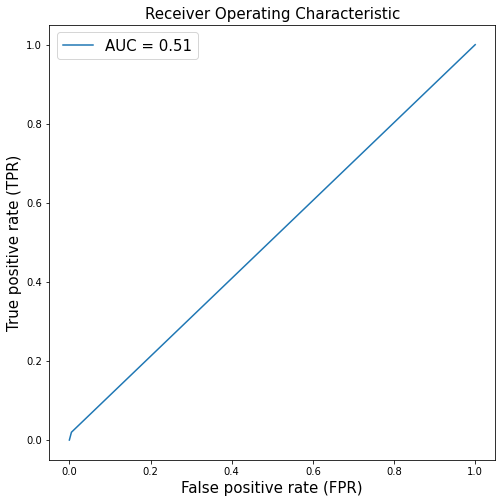

In [84]:
calc_and_plot_roc(y_val, y_pred)

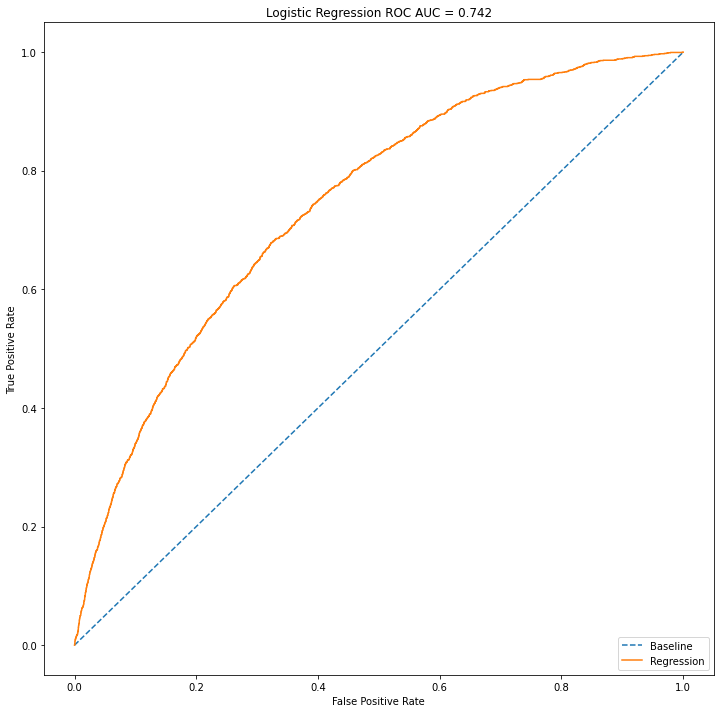

In [85]:
from sklearn.model_selection import GridSearchCV


model = LogisticRegression(max_iter=1000,class_weight='balanced', penalty='l2',C=1.0, random_state=42) #
model.fit(X_train, y_train)


probs = model.predict_proba(X_val)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Submission

In [86]:
test_pred = test.drop(['client_id','app_date'],axis=1)

In [87]:
sample_submission

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
...,...,...
24349,96657,0.144776
24350,65908,0.878936
24351,74542,0.830871
24352,82350,0.371539


In [88]:
predict_submission = model.predict_proba(test_pred)[:, 1]

In [89]:
predict_submission = pd.Series(predict_submission, name='default')

In [90]:
submission = pd.DataFrame([test.client_id,predict_submission]).T
submission.client_id = submission.client_id.apply(lambda x: int(x))
submission.to_csv('submission.csv', index=False)
submission

,client_id,default
0,74835,0.201023
1,17527,0.809407
2,75683,0.300836
3,26883,0.413978
4,28862,0.165556
...,...,...
36344,83775,0.746331
36345,106254,0.099418
36346,81852,0.772125
36347,1971,0.609103
